<a href="https://colab.research.google.com/github/Manuelstv/VIT-LSBGs/blob/main/VIT_version_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.1 MB/s 


In [ ]:
pip install tensorflow-determinism

  Created wheel for tensorflow-determinism: filename=tensorflow_determinism-0.3.0-py3-none-any.whl size=9158 sha256=d1a20f7416dce572231bdbbce9f062434c1c295953c203bbfd37f6b7c193c1cf
  Stored in directory: /root/.cache/pip/wheels/d2/be/33/2b27e81e5d40b4bfb7c103ac6c6c5e81fdbcf40d2af5078529
Successfully built tensorflow-determinism


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
import tensorflow_addons as tfa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

In [ ]:
# scikit-learn for Machine Learning
# Preprocessing
from sklearn.manifold import TSNE # Dimensionality reduction technique
from sklearn.model_selection import GridSearchCV #Cross-Validation
from sklearn.utils import resample #Resampling
# Metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [ ]:
SEED = 123456
import os
import random as rn
import numpy as np
import tensorflow as tf

os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)

from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
# Mount drive to upload the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
#Imagens classe positiva (LSBGs)
X_pos = np.float64(np.load("/content/drive/My Drive/datasets/original/LSBGs.npy"))
#Imagens classe negativa (artefato)
X_neg = np.float64(np.load("/content/drive/My Drive/datasets/original/negatives2.npy"))

#Ajuste de contraste

Pre processing method similar to then one used by Bom et al (2022).

You should only apply this method in .FITS images, since the pixel values can vary greatly. In .PNG images, pixels values are much more uniformized, so it doesn't make much sense to apply it.

In [ ]:
for i in range (np.shape(X_pos)[0]):
  lower_one, upper_one = np.percentile(X_pos[i], 5), np.percentile(X_pos[i], 95)
  X_pos[i] =  (X_pos[i] - lower_one) / (upper_one - lower_one)
  X_pos[i][X_pos[i] < 0] = 0
  X_pos[i][X_pos[i] > 1] = 1
  
  #power = 0.9
  #data_resized = data_resized**power
  #X_pos[i] = X_pos[i]**powe///r

for i in range (0,np.shape(X_neg)[0]):
  #print(i)
  lower_one, upper_one = np.percentile(X_neg[i], 1), np.percentile(X_neg[i], 90)
  X_neg[i] =  (X_neg[i] - lower_one) / (upper_one - lower_one)
  X_neg[i][X_neg[i] < 0] = 0
  X_neg[i][X_neg[i] > 1] = 1

  #power = 0.9
  #data_resized = data_resized**power
  #X_neg[i] = X_neg[i]**power

# Load data

Here you need to consider if you are going to use the same train, test and validation data multiple times or just for once.

- If you're gonna use the same x_train, x_test and x_val image Arrays - along with their corresponding y_train, y_test and y_val labels - multiple times, I reccomend you to save those arrays as .npy files and store in your drive. By doing that, the next time you run the code, just load the files - that will save you some time.

- On the other hand, if you are going to use a specific set of x_train, x_test and x_val images just for once (if you are testing the best parameters, for example), Then I reccomend you to NOT save the arrays. Again, this will save you some time and computer memory.   

In [ ]:
#x_train = np.zeros((30000,64,64,3))
#x_train[0:15000] = X_pos[0:15000]
#x_train[15000:30000] = X_neg[0:15000]

#y_train = np.zeros(30000)
#y_train[0:15000] = np.ones(15000)
#x_train, y_train = shuffle(x_train, y_train)

#np.save('x_train', x_train)
#np.save('y_train', y_train)

#load train data from .npy file
y_train = np.float64(np.load("/content/drive/My Drive/datasets/original/y_train.npy"))
x_train = np.float64(np.load("/content/drive/My Drive/datasets/original/x_train.npy"))

#x_val = np.zeros((5000,64,64,3))
#x_val[0:2500] = X_pos[15000:17500]
#x_val[2500:5000] = X_neg[15000:17500]

#y_val = np.zeros(5000)
#y_val[0:2500] = np.ones(2500)
#x_val, y_val = shuffle(x_val, y_val)

#np.save('y_val', y_val)
#np.save('x_val', x_val)

#load validation data from .npy file
y_val = np.float64(np.load("/content/drive/My Drive/datasets/original/y_val.npy"))
x_val = np.float64(np.load("/content/drive/My Drive/datasets/original/x_val.npy"))

#x_test = np.zeros((4995,64,64,3))
#x_test[0:2495] = X_pos[17500:19995]
#x_test[2495:4995] = X_neg[17500:20000]

#y_test = np.zeros(4995)
#y_test[0:2495] = np.ones(2495)
#x_test, y_test = shuffle(x_test, y_test)

#np.save('y_test', y_test)
#np.save('x_test', x_test)

#load test data from .npy file
y_test = np.float64(np.load("/content/drive/My Drive/datasets/original/y_test.npy"))
x_test = np.float64(np.load("/content/drive/My Drive/datasets/original/x_test.npy"))

## Prepare the data

In [ ]:
#number of classificatin classes
num_classes = 2
#image input shape
input_shape = (64, 64, 3)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape} - y_test shape: {y_val.shape}")

x_train shape: (30000, 64, 64, 3) - y_train shape: (30000,)
x_test shape: (4995, 64, 64, 3) - y_test shape: (4995,)
x_val shape: (5000, 64, 64, 3) - y_test shape: (5000,)


## Configure the hyperparameters

Those are the best we found until now, except epochs which we found that 25 is a good number.

In [ ]:
learning_rate = 0.002
weight_decay = 0.0001
batch_size = 256
num_epochs = 2 
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 10
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

## Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
           height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## Implement multilayer perceptron (MLP)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implement patch creation as a layer

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)

    return model

## Compile, train, and evaluate the mode

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/2
106/106 [==============================] - 135s 1s/step - loss: 2.2881 - accuracy: 0.7727 - top-5-accuracy: 1.0000 - val_loss: 0.3506 - val_accuracy: 0.8650 - val_top-5-accuracy: 1.0000
Epoch 2/2
157/157 [==============================] - 10s 64ms/step - loss: 0.2509 - accuracy: 0.9003 - top-5-accuracy: 1.0000
Test accuracy: 90.03%
Test top 5 accuracy: 100.0%


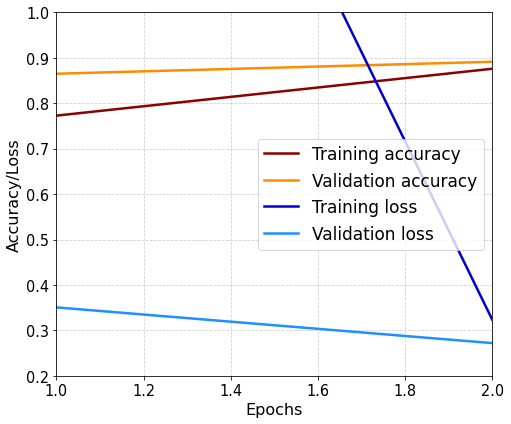

In [ ]:
Epochs = np.arange(1,num_epochs+1,1)
history_dict = history.history

train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_err = 1.0 - np.asarray(train_acc)
val_err = 1.0 - np.asarray(val_acc)

plt.figure(figsize=(7.2, 6.0))

# Plot Accuracy
plt.plot(Epochs, train_acc, c = 'darkred',linewidth=2.5,label='Training accuracy')
plt.plot(Epochs, val_acc , c = 'darkorange',linewidth=2.5,label='Validation accuracy')
# Plot Loss
plt.plot(Epochs, train_loss, c = 'mediumblue',linewidth=2.5,label='Training loss')
plt.plot(Epochs, val_loss , c = 'dodgerblue',linewidth=2.5,label='Validation loss')

plt.grid(ls='--',alpha=0.6)
plt.xlabel('Epochs', fontsize=16);plt.ylabel('Accuracy/Loss',fontsize=16)
plt.xlim(1,num_epochs)
plt.ylim(0.2,1)
plt.legend(frameon=True, loc='center right', fontsize=17)
plt.tick_params(axis='both', labelsize=14.5)

plt.tight_layout()
plt.show()

In [ ]:
# Predict on test data 
probs = tf.nn.softmax(vit_classifier.predict(x_test))
y_pred_DL= np.argmax(probs,axis=1)
#y_pred_DL = (tf.nn.softmax(vit_classifier.predict(x_test))(x_test)[:,1]) > 0.5)
# Print classification metrics 
print("Accuracy:",accuracy_score(y_test,y_pred_DL))
print("Precision:",precision_score(y_test,y_pred_DL))
print("Recall:",recall_score(y_test,y_pred_DL))

Accuracy: 0.9003003003003003
Precision: 0.8504738504738505
Recall: 0.9711422845691383


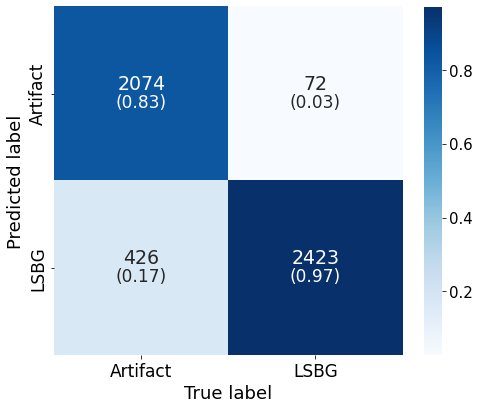

In [ ]:
# Get the confusion matrix
con_mat_DL = confusion_matrix(y_test, y_pred_DL)

# Get annotations and normalized confusion matrix
a = con_mat_DL[0]/np.sum(con_mat_DL[0])
b = con_mat_DL[1]/np.sum(con_mat_DL[1])

con_mat_normalized = np.zeros([2,2])
con_mat_normalized[0] = a
con_mat_normalized[1] = b

# Annotations
an_1 = "("+"{:.2f}".format(a[0])+")"
an_2 = "("+"{:.2f}".format(a[1])+")"
an_3 = "("+"{:.2f}".format(b[0])+")"
an_4 = "("+"{:.2f}".format(b[1])+")"

annots = np.zeros([2,2],dtype='U6')

annots[0,0] = an_1;annots[0,1] = an_2
annots[1,0] = an_3;annots[1,1] = an_4

class_names = ['Artifact','LSBG']

plt.figure(figsize = (7,6.0))
g =sns.heatmap(con_mat_DL.T, square = True, annot=True,annot_kws={'va':'bottom',"size": 19},fmt='.0f', cmap='Blues', cbar=False, 
           xticklabels= class_names,
           yticklabels= class_names)
sns.heatmap(con_mat_normalized.T, square=True, annot=annots.T, annot_kws={'va':'top',"size": 17},cmap='Blues',fmt='', cbar=True,
            cbar_kws={'shrink':0.94})
g.set_xticklabels(class_names, fontsize = 17)
g.set_yticklabels(class_names, fontsize = 17)

# Ticks for colorbar
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
plt.xlabel('True label',fontsize=18)
plt.ylabel('Predicted label',fontsize=18)

plt.tight_layout()
plt.show()

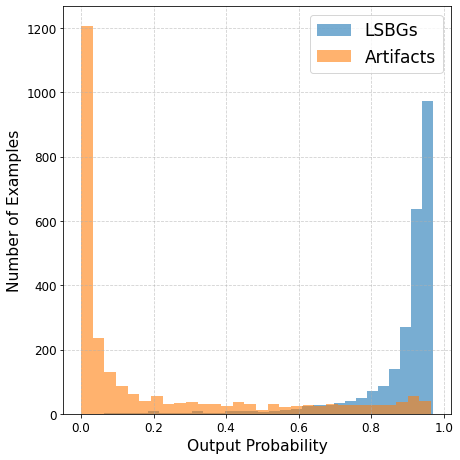

In [ ]:
# First let's predict probabilities on the test set
scores_DL = probs[:,1]

plt.figure(figsize = (6.5,6.5))

plt.hist(scores_DL[y_test==1.0],bins=30,alpha=0.6,density=False,label='LSBGs')
plt.hist(scores_DL[y_test==0.0],bins=30,alpha=0.6,density=False,label='Artifacts')
plt.grid(ls='--',alpha=0.6)
plt.tick_params(axis='both', labelsize=12)
plt.legend(frameon=True, loc='upper right', fontsize=17)

plt.xlabel("Output Probability", fontsize=15.5)
plt.ylabel("Number of Examples", fontsize=15.5)

plt.tight_layout()
plt.show()

# Plot Artifacts misclassificated as LSBGs

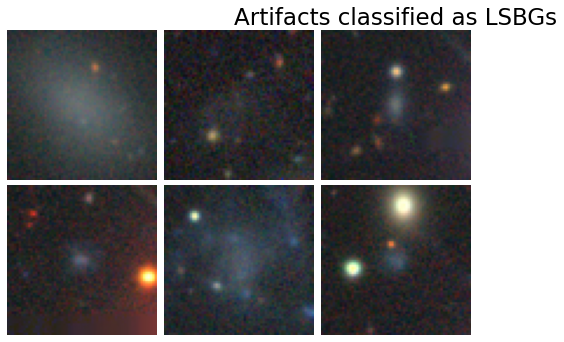

In [ ]:
X_misc_LSBG = x_test[(scores_DL<0.2)&(y_test==1.0)] #LSBGs classified as Artefacts
n_rows = 2
n_cols = 3

plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Artifacts classified as LSBGs",fontsize=23)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_misc_LSBG[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
plt.show()

In [ ]:
def bootstrap(y_pred, y_pred_proba,y_test_loc):
  n_bootstraps = 1000 

  # Classification metrics that we want to estimate
  # ===============================================================
  boot_accuracy = np.zeros(n_bootstraps)
  boot_precision = np.zeros(n_bootstraps) #Also known as purit
  boot_recall = np.zeros(n_bootstraps) # Also known as completeness
  boot_tprs = np.zeros((n_bootstraps,200)) # True positive rates
  boot_auc = np.zeros(n_bootstraps) # AUC
  fprs = np.linspace(0,1,200) # False positive rates
  # ===============================================================
  indices = np.arange(len(y_test_loc))

  for i in range(n_bootstraps):
    # Get local indices by resampling
    ind_loc = resample(indices, n_samples=len(indices), replace=True)
    print(len(indices))

    # ================================================================================
    # Now get "local" test samples, meaning those resulting from resampling

    y_pred_loc = y_pred[ind_loc]  #Prediction 
    y_pred_prob_loc = y_pred_proba[ind_loc] #Probability prediction
    y_true_loc = y_test_loc[ind_loc] #True labels of the test set

    # ================================================================================

    # Now estimate the evaluation metrics for the current resampling

    boot_accuracy[i] = accuracy_score(y_true_loc, y_pred_loc) #Accuracy
    boot_precision[i] = precision_score(y_true_loc, y_pred_loc) #Precision
    boot_recall[i] = recall_score(y_true_loc, y_pred_loc) #Recall
    boot_auc[i] = roc_auc_score(y_true_loc, y_pred_prob_loc[:,1]) #AUC score 

    # And now for the true positive rate, in order to get the errors on the ROC curve

    fpr_loc, tpr_loc, thresholds_loc = roc_curve(y_true_loc, y_pred_prob_loc[:,1], pos_label=1.0)
    fpr_unique, ind_unique = np.unique(fpr_loc,return_index=True)
    tpr_unique = tpr_loc[ind_unique]

    # interpolate the false positive - true positives
    interp = interpolate.interp1d(fpr_unique, tpr_unique, kind='linear')
    boot_tprs[i,:] = interp(fprs)

  return boot_accuracy,boot_precision,boot_recall,boot_auc,boot_tprs

In [ ]:
scores_DL = vit_classifier.predict(x_test)
AUC_DL = roc_auc_score(y_test, scores_DL[:,1])
print("AUC:",AUC_DL)

In [ ]:
from scipy import interpolate
acc_boot_DL, prec_boot_DL, rec_boot_DL, auc_boot_DL, tprs_boot_DL = bootstrap(y_pred_DL, scores_DL, y_test)

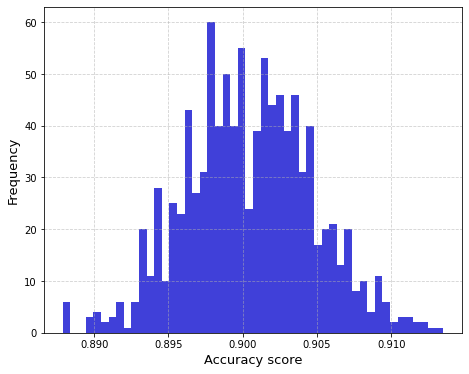

In [ ]:
plt.figure(figsize=(7.5, 6.0))

plt.hist(acc_boot_DL, bins=50,color='mediumblue',alpha=0.75)
plt.grid(ls='--',alpha=0.6)

plt.xlabel('Accuracy score',fontsize=13);plt.ylabel('Frequency',fontsize=13)
plt.show()

In [ ]:
# Precision
prec_boot_DL.sort()
# Computing the lower and upper bound of the 95% confidence interval
conf_lower_prec_DL = prec_boot_DL[int(0.025 * len(prec_boot_DL))]
conf_upper_prec_DL = prec_boot_DL[int(0.975 * len(prec_boot_DL))]
print("Precision confidence intervals:",conf_lower_prec_DL,conf_upper_prec_DL)


# Recall
rec_boot_DL.sort()
# Computing the lower and upper bound of the 95% confidence interval
conf_lower_rec_DL = rec_boot_DL[int(0.025 * len(rec_boot_DL))]
conf_upper_rec_DL = rec_boot_DL[int(0.975 * len(rec_boot_DL))]
print("Recall confidence intervals:",conf_lower_rec_DL,conf_upper_rec_DL)


# AUC score
auc_boot_DL.sort()
# Computing the lower and upper bound of the 95% confidence interval
conf_lower_auc_DL = auc_boot_DL[int(0.025 * len(auc_boot_DL))]
conf_upper_auc_DL = auc_boot_DL[int(0.975 * len(auc_boot_DL))]
print("AUC confidence intervals:",conf_lower_auc_DL,conf_upper_auc_DL)

# Accuracy
acc_boot_DL.sort()
# Computing the lower and upper bound of the 95% confidence interval
conf_lower_acc_DL = acc_boot_DL[int(0.025 * len(acc_boot_DL))]
conf_upper_acc_DL = acc_boot_DL[int(0.975 * len(acc_boot_DL))]
print("Acuracy confidence intervals:",conf_lower_acc_DL,conf_upper_acc_DL)

Precision confidence intervals: 0.8376669009135629 0.865045806906272
Recall confidence intervals: 0.9643846458250891 0.9775784753363229
AUC confidence intervals: 0.9546258147903272 0.9655172192650551
Acuracy confidence intervals: 0.8926926926926927 0.9091091091091091


In [ ]:
scores_DL = vit_classifier.predict(x_test)
fpr_DL, tpr_DL, thresholds_DL = roc_curve(y_test, scores_DL[:,1], pos_label=1.0)

In [ ]:
fprs = np.linspace(0,1,200) # False positive rates

# Create empty arrays - to store the intervals
lower_tprs_DL = np.zeros(200)
upper_tprs_DL = np.zeros(200)

for i in range(200):
  tprs_boot_DL_loc = tprs_boot_DL[:,i]

  #sort it
  tprs_boot_DL_loc.sort()
  # Compute the lower and upper bound of the 95% confidence interval
  lower_tprs_DL[i] = tprs_boot_DL_loc[int(0.025 * len(tprs_boot_DL_loc))]
  upper_tprs_DL[i] = tprs_boot_DL_loc[int(0.975 * len(tprs_boot_DL_loc))]  

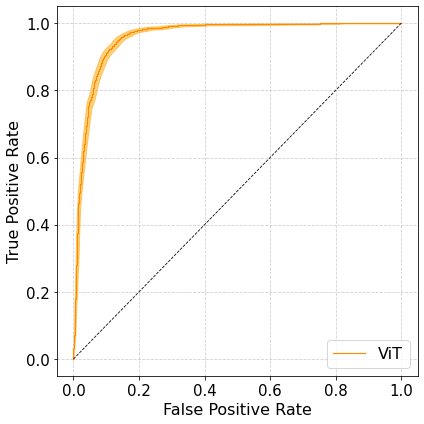

In [ ]:
x = np.linspace(0,1,100)
plt.figure(figsize = (6.0,6.0))

# Deep Learning and confidence interval
plt.plot(fpr_DL,tpr_DL,c='darkorange',linewidth=1.2, label='ViT')
plt.fill_between(fprs,lower_tprs_DL, upper_tprs_DL,color='orange',rasterized=True,alpha=0.5)

plt.plot(x,x, c='k',ls='--',linewidth=0.8)
plt.grid(ls='--', alpha=0.6)

#plt.title('ROC curve')
plt.xlabel('False Positive Rate',fontsize=16);plt.ylabel('True Positive Rate',fontsize=16)
plt.legend(frameon=True, loc='lower right', fontsize=16)
plt.tick_params(axis='both', labelsize=15)

plt.tight_layout()
plt.show()